In [35]:
# --- Reproducible environment & lightweight utilities ---
from __future__ import annotations

import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split

# --- Training utilities ---
from sklearn.metrics import (
    roc_auc_score, average_precision_score, accuracy_score, f1_score,
    roc_curve, precision_recall_curve, confusion_matrix, classification_report
)
from tqdm.auto import tqdm
import math


# Plot defaults: consistent sizing and readable grids
plt.rcParams["figure.figsize"] = (9, 5)
plt.rcParams["axes.grid"] = True
plt.rcParams["figure.dpi"] = 140

# Keep the console clean from non-critical warnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# Reproducibility
RNG_SEED = 42
rng = np.random.default_rng(RNG_SEED)

# Project paths
TRAIN_DATASET = "../data/train.csv"
TEST_DATASET = "../data/test.csv"
MODEL_PATH = "../models"

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)

Device: cuda


# Data Cleaning & Alignment

Before any feature engineering or modeling, we ensure both **train** and **test** datasets share the exact same structure.  
This involves removing columns that are not available in both sets (to avoid data leakage),  
isolating the **target variable** (`trip_duration`), and preserving **ID columns** separately for evaluation and submission.

Steps:
1. Drop `dropoff_datetime` from the training data — it's unavailable in test and leaks target information.  
2. Split the target column (`trip_duration`) from the training features.  
3. Store `id` columns separately to use later when generating the submission file.  
4. Remove `id` from features (since it has no predictive value).  
5. Validate that train and test feature sets are perfectly aligned.  
This ensures both datasets are **schema-consistent**, **leak-free**, and ready for feature extraction.


In [2]:
# load dataset
df_train = pd.read_csv(TRAIN_DATASET)
df_test = pd.read_csv(TEST_DATASET)

In [3]:
df_train.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration'],
      dtype='object')

In [4]:
df_test.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'passenger_count',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'store_and_fwd_flag'],
      dtype='object')

In [5]:
# ============================================================
# Clean alignment between train and test datasets
# ============================================================

# --- 1. Drop columns from train that do not exist in test ---
# (dropoff_datetime leaks the target information)
df_train = df_train.drop(columns=["dropoff_datetime"])
# --- 2. Separate the target variable (trip_duration) ---
target_col = "trip_duration"
y_train = df_train[target_col]
X_train = df_train.drop(columns=[target_col])
# --- 3. Keep ID columns separately for later submission/evaluation ---
train_ids = X_train["id"].copy()
test_ids = df_test["id"].copy()
# --- 4. Drop ID columns from the feature sets (not predictive) ---
X_train = X_train.drop(columns=["id"])
X_test = df_test.drop(columns=["id"])
print(f"Shapes aligned: X_train={X_train.shape}, X_test={X_test.shape}")
print(f"Target shape: y_train={y_train.shape}")
print(f"Feature columns: {X_train.columns.tolist()}")

Shapes aligned: X_train=(1458644, 8), X_test=(625134, 8)
Target shape: y_train=(1458644,)
Feature columns: ['vendor_id', 'pickup_datetime', 'passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag']


In [6]:
display(X_train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 8 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   vendor_id           1458644 non-null  int64  
 1   pickup_datetime     1458644 non-null  object 
 2   passenger_count     1458644 non-null  int64  
 3   pickup_longitude    1458644 non-null  float64
 4   pickup_latitude     1458644 non-null  float64
 5   dropoff_longitude   1458644 non-null  float64
 6   dropoff_latitude    1458644 non-null  float64
 7   store_and_fwd_flag  1458644 non-null  object 
dtypes: float64(4), int64(2), object(2)
memory usage: 89.0+ MB


None

In [7]:
display(X_train["store_and_fwd_flag"].unique())

array(['N', 'Y'], dtype=object)

In [8]:
# Convert the categorical flag ('N'/'Y') into a binary numeric feature (0/1)
# 'N' → 0 means no message stored/forwarded
# 'Y' → 1 means the trip record was stored and forwarded
for df in (X_train, X_test):
    df["store_and_fwd_flag"] = df["store_and_fwd_flag"].map({"N": 0, "Y": 1}).astype(int)

In [9]:
display(X_train["pickup_datetime"].head())

0    2016-03-14 17:24:55
1    2016-06-12 00:43:35
2    2016-01-19 11:35:24
3    2016-04-06 19:32:31
4    2016-03-26 13:30:55
Name: pickup_datetime, dtype: object

In [10]:
# ============================================================
# Datetime feature engineering for pickup_datetime
# ============================================================

def add_pickup_datetime_features(df: pd.DataFrame, col: str = "pickup_datetime") -> pd.DataFrame:
    """
    Expand the pickup datetime column into a set of meaningful numerical features.

    This transformation:
    - Parses the raw timestamp into a proper datetime object.
    - Extracts calendar/time components (year, month, day, hour, minute, weekday).
    - Adds a weekend indicator.
    - Adds cyclic encodings for hour-of-day and day-of-week to capture periodic patterns.
    - Drops the original datetime column once all features are derived.

    The function returns a new DataFrame with the additional columns.
    """
    # Parse the datetime column (errors coerced to NaT to avoid hard crashes on bad rows)
    dt = pd.to_datetime(df[col], errors="coerce")

    # Basic calendar components
    df["pickup_year"] = dt.dt.year
    df["pickup_month"] = dt.dt.month
    df["pickup_day"] = dt.dt.day
    df["pickup_hour"] = dt.dt.hour
    df["pickup_minute"] = dt.dt.minute
    df["pickup_dayofweek"] = dt.dt.dayofweek  # 0 = Monday, 6 = Sunday

    # Weekend flag: 1 if Saturday/Sunday, else 0
    df["is_weekend"] = (df["pickup_dayofweek"] >= 5).astype(int)

    # Cyclic encoding for hour of day (24-hour cycle)
    df["pickup_hour_sin"] = np.sin(2 * np.pi * df["pickup_hour"] / 24)
    df["pickup_hour_cos"] = np.cos(2 * np.pi * df["pickup_hour"] / 24)

    # Cyclic encoding for day of week (7-day cycle)
    df["pickup_dow_sin"] = np.sin(2 * np.pi * df["pickup_dayofweek"] / 7)
    df["pickup_dow_cos"] = np.cos(2 * np.pi * df["pickup_dayofweek"] / 7)

    # Drop the original raw datetime column to keep the feature space purely numeric
    df = df.drop(columns=[col])

    return df

In [11]:
# Apply the same transformation to both train and test feature sets
X_train = add_pickup_datetime_features(X_train, col="pickup_datetime")
X_test = add_pickup_datetime_features(X_test, col="pickup_datetime")

In [13]:
X_train.head()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,pickup_year,pickup_month,pickup_day,pickup_hour,pickup_minute,pickup_dayofweek,is_weekend,pickup_hour_sin,pickup_hour_cos,pickup_dow_sin,pickup_dow_cos
0,2,1,-73.982155,40.767937,-73.964630,40.765602,0,2016,3,14,17,24,0,0,-0.965926,-0.258819,0.000000,1.000000
1,1,1,-73.980415,40.738564,-73.999481,40.731152,0,2016,6,12,0,43,6,1,0.000000,1.000000,-0.781831,0.623490
2,2,1,-73.979027,40.763939,-74.005333,40.710087,0,2016,1,19,11,35,1,0,0.258819,-0.965926,0.781831,0.623490
3,2,1,-74.010040,40.719971,-74.012268,40.706718,0,2016,4,6,19,32,2,0,-0.965926,0.258819,0.974928,-0.222521
4,2,1,-73.973053,40.793209,-73.972923,40.782520,0,2016,3,26,13,30,5,1,-0.258819,-0.965926,-0.974928,-0.222521


In [15]:
print(y_train.head())

0     455
1     663
2    2124
3     429
4     435
Name: trip_duration, dtype: int64


In [33]:
# Map vendor_id from {1,2} to {0,1}
for df in (X_train, X_test):
    df["vendor_id"] = df["vendor_id"].map({1: 0, 2: 1}).astype(int)

In [36]:
# ============================================================
# Split training data into train/validation subsets
# ============================================================

# We'll keep aside a small fraction for internal validation.
# This helps us tune hyperparameters and check overfitting.
X_train_split, X_val, y_train_split, y_val = train_test_split(
    X_train, y_train,
    test_size=0.02,             # 2% for validation
    random_state=RNG_SEED,      
    shuffle=True
)
X_train_main, X_test_from_train, y_train_main, y_test_from_train = train_test_split(
    X_train_split, y_train_split,
    test_size=0.02,
    random_state=RNG_SEED,
    shuffle=True
)

In [39]:
print("Train main:", X_train_main.shape, y_train_main.shape)
print("Val:", X_val.shape, y_val.shape)
print("Test-from-train:", X_test_from_train.shape, y_test_from_train.shape)

Train main: (1400881, 18) (1400881,)
Val: (29173, 18) (29173,)
Test-from-train: (28590, 18) (28590,)


In [40]:
X_train_main.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1400881 entries, 1410218 to 460979
Data columns (total 18 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   vendor_id           1400881 non-null  int64  
 1   passenger_count     1400881 non-null  int64  
 2   pickup_longitude    1400881 non-null  float64
 3   pickup_latitude     1400881 non-null  float64
 4   dropoff_longitude   1400881 non-null  float64
 5   dropoff_latitude    1400881 non-null  float64
 6   store_and_fwd_flag  1400881 non-null  int64  
 7   pickup_year         1400881 non-null  int32  
 8   pickup_month        1400881 non-null  int32  
 9   pickup_day          1400881 non-null  int32  
 10  pickup_hour         1400881 non-null  int32  
 11  pickup_minute       1400881 non-null  int32  
 12  pickup_dayofweek    1400881 non-null  int32  
 13  is_weekend          1400881 non-null  int64  
 14  pickup_hour_sin     1400881 non-null  float64
 15  pickup_hour_cos

In [44]:
# ============================================================
# Drop redundant or uninformative datetime columns
# ============================================================

cols_to_drop = ["pickup_year", "pickup_hour", "pickup_dayofweek"]

for df in (X_train_main, X_val, X_test_from_train, X_test):
    df.drop(columns=cols_to_drop, inplace=True, errors="ignore")

print("Dropped redundant columns:", cols_to_drop)
print("Remaining feature count:", X_train_main.shape[1])
print("Feature columns now aligned across all datasets.")

Dropped redundant columns: ['pickup_year', 'pickup_hour', 'pickup_dayofweek']
Remaining feature count: 15
Feature columns now aligned across all datasets.


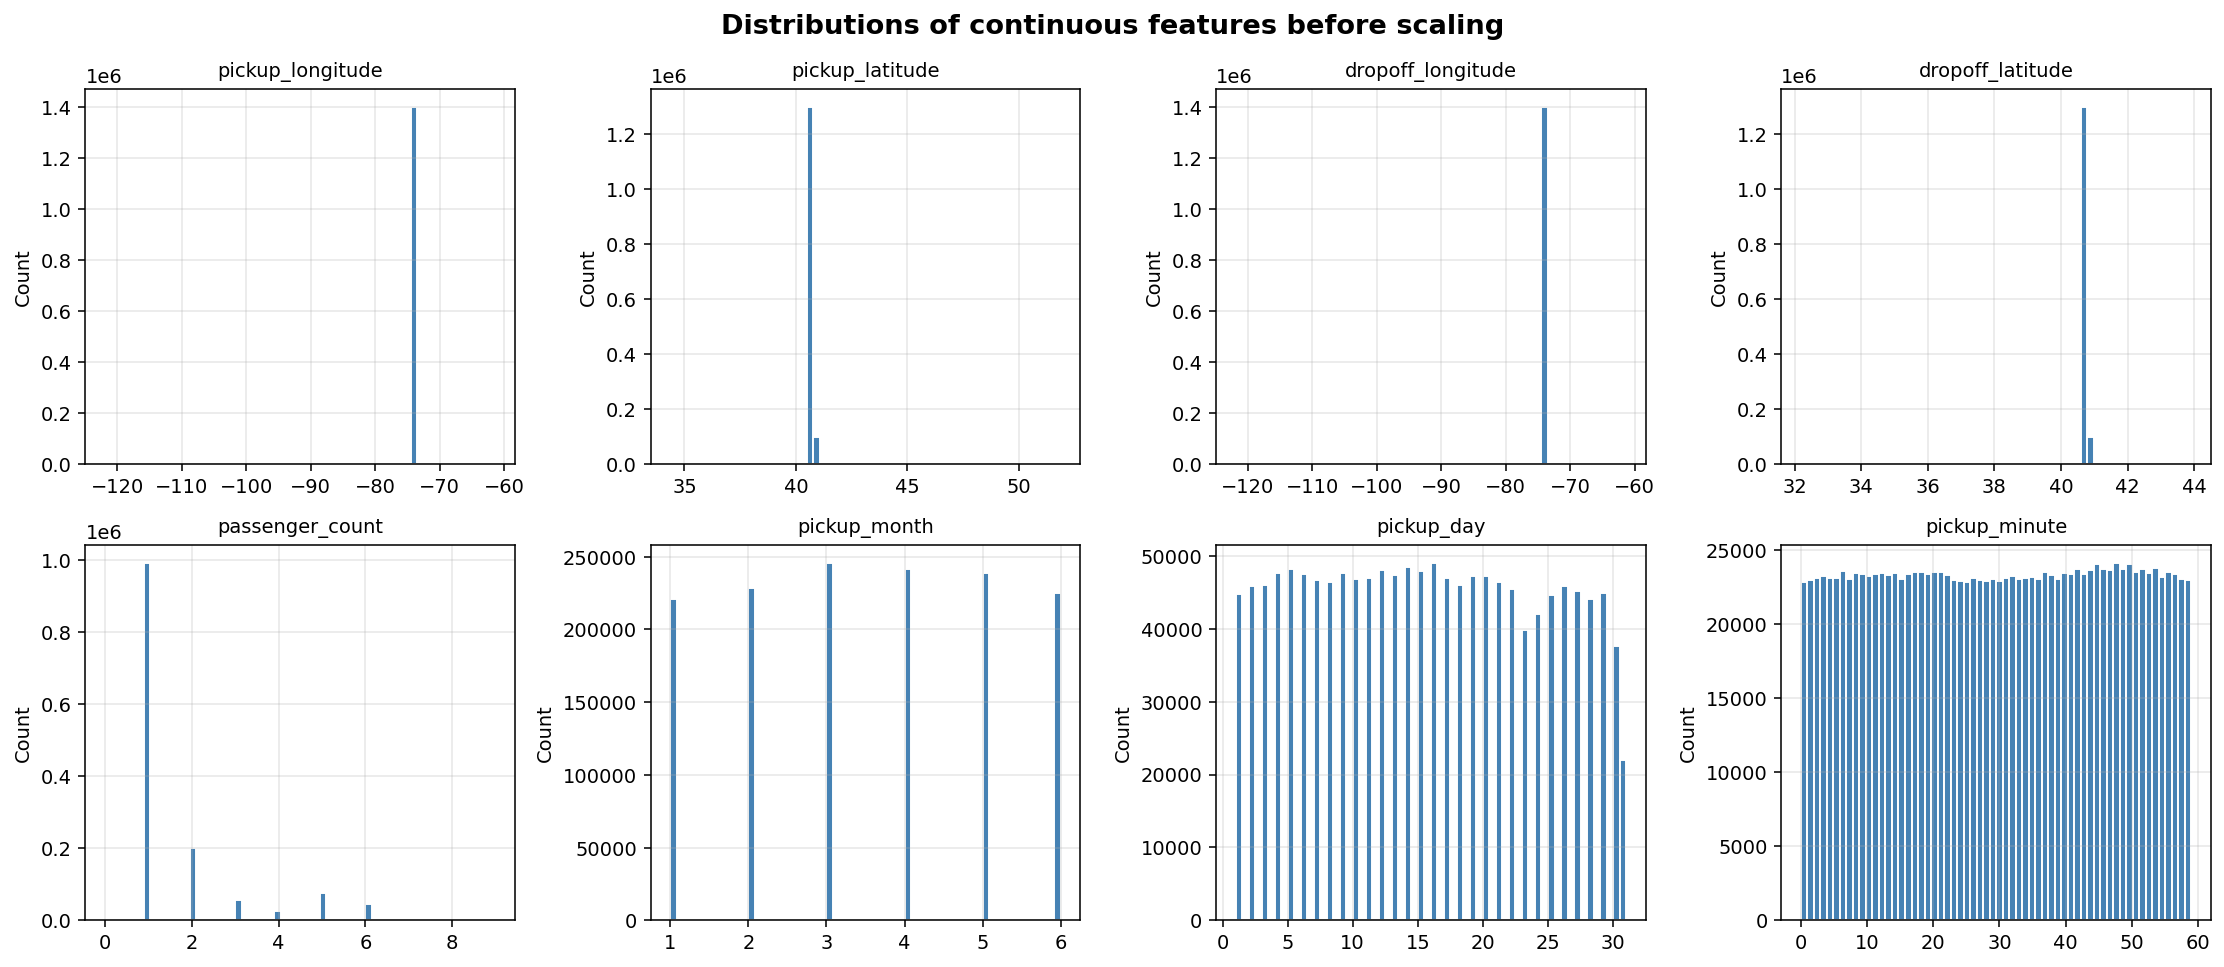

In [45]:
# ============================================================
# Quick visualization of numeric feature distributions
# ============================================================
cols_to_plot = [
    "pickup_longitude", "pickup_latitude",
    "dropoff_longitude", "dropoff_latitude",
    "passenger_count", "pickup_month",
    "pickup_day", "pickup_minute"
]

fig, axes = plt.subplots(2, 4, figsize=(16, 7))
axes = axes.flatten()

for i, col in enumerate(cols_to_plot):
    ax = axes[i]
    ax.hist(X_train_main[col], bins=60, color="steelblue", edgecolor="white")
    ax.set_title(col, fontsize=10)
    ax.set_xlabel("")  # clean layout
    ax.set_ylabel("Count")
    ax.grid(True, alpha=0.3)

fig.suptitle("Distributions of continuous features before scaling", fontsize=14, weight="bold")
plt.tight_layout()
plt.show()


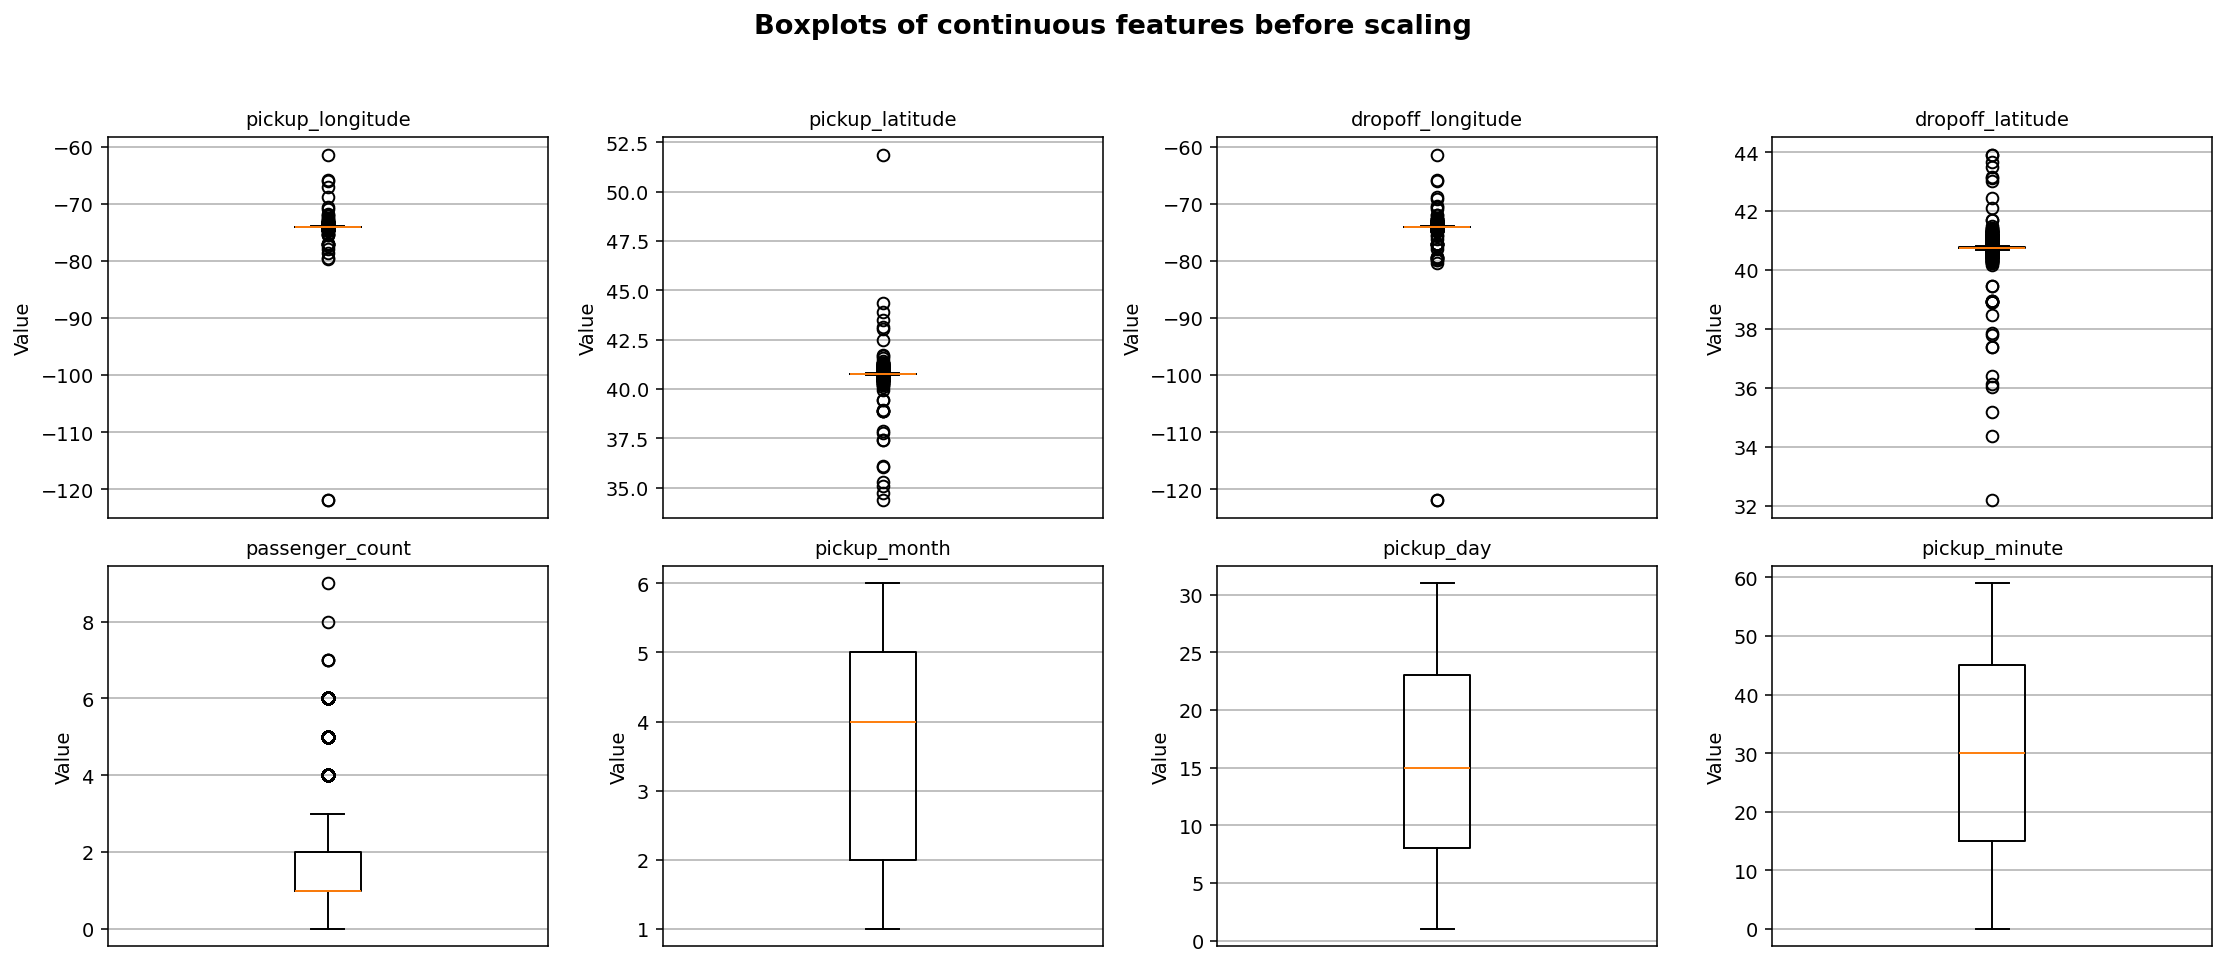

In [46]:
# ============================================================
# Boxplots of numeric feature distributions
# ============================================================
cols_to_plot = [
    "pickup_longitude", "pickup_latitude",
    "dropoff_longitude", "dropoff_latitude",
    "passenger_count", "pickup_month",
    "pickup_day", "pickup_minute"
]

fig, axes = plt.subplots(2, 4, figsize=(16, 7))
axes = axes.flatten()

for i, col in enumerate(cols_to_plot):
    ax = axes[i]
    ax.boxplot(X_train_main[col].dropna(), vert=True, showfliers=True)
    ax.set_title(col, fontsize=10)
    ax.set_xticks([])          # sin labels en el eje x (solo una caja)
    ax.set_ylabel("Value")

fig.suptitle("Boxplots of continuous features before scaling", fontsize=14, weight="bold")
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [49]:
# ============================================================
# Custom transformers
# ============================================================
class QuantileClipper(BaseEstimator, TransformerMixin):
    """
    Per-column winsorization: clip each feature to [q_low, q_high] based on
    empirical quantiles computed on the training data.

    Useful for heavy-tailed continuous features and to reduce the influence of
    extreme outliers without fully discarding samples.
    """
    def __init__(self, low=0.01, high=0.99):
        self.low = low
        self.high = high

    def fit(self, X, y=None):
        X = np.asarray(X, dtype=float)
        self.q_low_ = np.nanquantile(X, self.low, axis=0)
        self.q_high_ = np.nanquantile(X, self.high, axis=0)
        return self

    def transform(self, X):
        X = np.asarray(X, dtype=float)
        return np.clip(X, self.q_low_, self.q_high_)


class ValueClipper(BaseEstimator, TransformerMixin):
    """
    Clip all values to a fixed [min_val, max_val] range.
    Intended for variables with known plausible bounds.
    """
    def __init__(self, min_val=None, max_val=None):
        self.min_val = min_val
        self.max_val = max_val

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = np.asarray(X, dtype=float)
        if self.min_val is not None:
            X = np.maximum(X, self.min_val)
        if self.max_val is not None:
            X = np.minimum(X, self.max_val)
        return X
    
# ============================================================
# Column groups
# ============================================================

ALL_FEATURES = list(X_train_main.columns)

# Binary features (already 0/1)
BINARY_COLS = ["vendor_id", "store_and_fwd_flag", "is_weekend"]

# Cyclic datetime features (already in [-1, 1])
CYCLIC_COLS = [
    "pickup_hour_sin", "pickup_hour_cos",
    "pickup_dow_sin", "pickup_dow_cos",
]

# Continuous / discrete numeric features to scale
GEO_LON_COLS = ["pickup_longitude", "dropoff_longitude"]
GEO_LAT_COLS = ["pickup_latitude", "dropoff_latitude"]
PASSENGER_COL = ["passenger_count"]
DATE_DISCRETE_COLS = ["pickup_month", "pickup_day", "pickup_minute"]

NUMERIC_COLS = GEO_LON_COLS + GEO_LAT_COLS + PASSENGER_COL + DATE_DISCRETE_COLS

# Sanity check: ensure we covered all features
covered = set(BINARY_COLS + CYCLIC_COLS + NUMERIC_COLS)
missing = set(ALL_FEATURES) - covered
assert not missing, f"Unhandled feature columns: {missing}"

# ============================================================
# Pipelines for each block
# ============================================================

# Longitudes: clip to a plausible NYC bounding box, winsorize tails, robust scale
geo_lon_pipe = Pipeline(steps=[
    ("clip_bbox", ValueClipper(min_val=-74.3, max_val=-73.5)),
    ("winsor", QuantileClipper(low=0.001, high=0.999)),
    ("scaler", RobustScaler()),
])

# Latitudes: same idea with appropriate bounds
geo_lat_pipe = Pipeline(steps=[
    ("clip_bbox", ValueClipper(min_val=40.5, max_val=41.0)),
    ("winsor", QuantileClipper(low=0.001, high=0.999)),
    ("scaler", RobustScaler()),
])

# Passenger count: enforce [1, 6] and scale
passenger_pipe = Pipeline(steps=[
    ("clip", ValueClipper(min_val=1, max_val=6)),
    ("winsor", QuantileClipper(low=0.001, high=0.999)),
    ("scaler", RobustScaler()),
])

# Discrete calendar features: simple robust scaling is enough
date_pipe = Pipeline(steps=[
    ("scaler", RobustScaler()),
])

# ============================================================
# Main ColumnTransformer
# ============================================================

preprocess = ColumnTransformer(
    transformers=[
        ("geo_lon", geo_lon_pipe, GEO_LON_COLS),
        ("geo_lat", geo_lat_pipe, GEO_LAT_COLS),
        ("passenger", passenger_pipe, PASSENGER_COL),
        ("date_disc", date_pipe, DATE_DISCRETE_COLS),
        ("binary", "passthrough", BINARY_COLS),
        ("cyclic", "passthrough", CYCLIC_COLS),
    ],
    remainder="drop",
    verbose_feature_names_out=False,
)

# ============================================================
# Fit on train_main, apply to all splits
# ============================================================

X_train_main_t = preprocess.fit_transform(X_train_main)
X_val_t = preprocess.transform(X_val)
X_test_from_train_t = preprocess.transform(X_test_from_train)
X_test_t = preprocess.transform(X_test)

print("Transformed shapes:")
print("  Train main:", X_train_main_t.shape)
print("  Val:", X_val_t.shape)
print("  Test-from-train:", X_test_from_train_t.shape)
print("  Kaggle test:", X_test_t.shape)

# ============================================================
# Target transformation (log1p for trip_duration)
# ============================================================

# We train the regression model on log1p(trip_duration) to stabilize the loss
# and reduce the impact of extremely long trips.
y_train_main_log = np.log1p(y_train_main.values)
y_val_log = np.log1p(y_val.values)
y_test_from_train_log = np.log1p(y_test_from_train.values)

print("Target transformed with log1p().")

Transformed shapes:
  Train main: (1400881, 15)
  Val: (29173, 15)
  Test-from-train: (28590, 15)
  Kaggle test: (625134, 15)
Target transformed with log1p().
